# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID :

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

## Preprocess

In [14]:
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')]
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0

    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)


    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['date'] = df1['creationdate'].dt.date

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

    enc1 = LabelEncoder()
    enc1.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df1['currencycode'])
    df1['currencycode'] = enc2.transform(df1.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

    df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
    df1['accountcode_cc'] = 0
    df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
    df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
    df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
    df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

    enc4 = LabelEncoder()
    enc4.fit(df1['accountcode'])
    df1['accountcode'] = enc4.transform(df1.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df1['mail_id'])
    df1['mail_id'] = enc6.transform(df1.mail_id)

    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    df1['day_of_week'] = df1['creationdate'].dt.dayofweek

    df1['hour'] = df1['creationdate'].dt.hour

    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate']=dates
    
    return df1

In [15]:
data = "data_for_student_case.csv"
df = pd.read_csv(data)

df1 = preprocess(df)

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

In [16]:
df1.columns

Index(['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id', 'date',
       'amount_eur', 'accountcode_cc', 'countries_equal', 'day_of_week',
       'hour'],
      dtype='object')

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 2. Imbalance task – 1 A4 – Individual

In [17]:
'''
SMOTE function:
T => Number of minority Samples available
N => No. synthetic samples to be generated (in % of T)
k => No. of nearest neighbours to be considered
returns a list of synthetic samples
'''

import random
import math

def smote(T,N,k):
#     if N < 100, sample from random percent of minority instances
    if N < 100:
        T = (N/100) * T
        N = 100 # since we changed T now, make N = 100
        
#     N controls the number of synthetic samples generated per data point
    N = (int)(N/100)
    synthetic_samples = list()
    
    for i in range(T):
        counter = N
        nn_list = k_neighbors(minority_samples[i], minority_samples, k)
        while counter:
            rand_nn = random.randint(1, len(nn_list))
            sample_row = []
            for attr in range(len(minority_samples[i])):
                diff = minority_samples[rand_nn][attr] - minority_samples[i][attr]
                rand_gap = random.uniform(0, 1)
                sample_row.append(int(minority_samples[i][attr] + rand_gap*diff))
            synthetic_samples.append    
            synthetic_samples.append(sample_row)
            counter = counter - 1
    
    return synthetic_samples

def k_neighbors(curr_row, data, k):
    dist_list = list()
    for idx in range(len(data)):
        dist = euclidean_distance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
    for i in range(k):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours
    
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

In [19]:
# Shape the data and apply SMOTE

df_minority = df1.loc[df1['simple_journal'] == 1]
df_minority.drop(columns=['txid','bookingdate','date','accountcode_cc'],inplace=True)
minority_samples = np.array(df_minority)

synthetic_samples = smote(len(minority_samples), 100, 2)
synthetic=pd.DataFrame(synthetic_samples,columns=['issuercountrycode', 'txvariantcode', 'bin', 'amount', 
                                            'currencycode', 'shoppercountrycode', 'shopperinteraction',
                                            'simple_journal',
                                            'cardverificationcodesupplied', 'cvcresponsecode','creationdate', 'accountcode',
                                            'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 
                                            'day_of_week', 'hour'])  
synthetic.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal,day_of_week,hour
0,104,2,1975,91859,2,104,1,1,1,0,1435802130,1,128641,7593,115485,63,1,2,18
1,104,2,2364,44900,2,104,1,1,1,0,1435812655,1,834,194109,44739,21,1,3,4
2,104,2,1965,149900,2,104,1,1,1,0,1435847428,1,119287,189655,122802,70,1,3,14
3,104,2,2370,51134,2,104,1,1,1,0,1435875606,1,12789,12871,55431,50,1,3,4
4,104,2,1958,106338,2,104,1,1,1,0,1436020088,1,118153,195548,199489,57,1,2,17


False


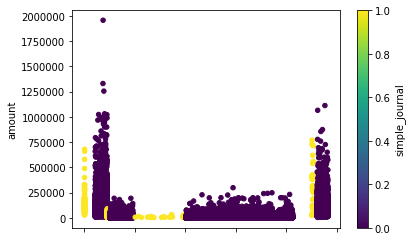

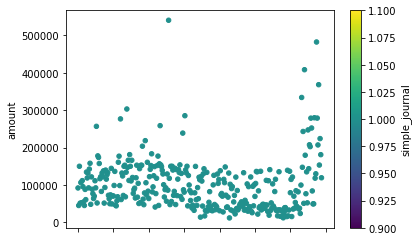

In [39]:
# Scatter Plots
ax1 = df1.plot.scatter(x='txid', y='amount', c='simple_journal', colormap='viridis')
synthetic.reset_index().plot.scatter(x='index', y='amount', c='simple_journal', colormap='viridis')


### 2a. Print ROC curves

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below